# The FFT algorithm

## Direct DFT
The fourier transofrm of a function $f(x)$ is the function $F(\omega)$ defined as:

$$F(\omega)=\int_{-\infty}^{\infty}f(x)e^{i\omega x}dx $$

with inverse Fourier transofrm defined as:

$$f(x)=\frac{1}{2\pi}\int_{-\infty}^{\infty}F(\omega)e^{i\omega x}d\omega. $$

When working with digital audio, the object of the examination is not a continuous wave but a discrete sequence of PCM samples that represent, digitally, air pressure in the domain of time. This brings us to the _discrete_ version of the fourier transform:

$$ X_k=\sum_{n=0}^{N-1}x_ne^{-i\frac{2\pi}{N}kn}.$$

This is often written as

$$X_k=\sum_{n=0}^{N-1}x_nW^{kn}_{N}$$

where $ W_{N} = e^{-i\frac{2\pi}{N}}$ is often referred to as _twiddle factor_ and refers to the $N-th$ roots of the unit circle of the complex plane. These factors can be interpreted as different "rotations" of the input numbers around the complex circle.

This transformation, in particular, accepts as  input a vector of $N$ numbers (in our case, audio samples) $x_n$ for $n=0,\ldots,N-1$ and outputs a vector of $N$ complex numbers $X_n$ that represent the frequency components of the signal represented by the samples in input. The $N$ complex numbers represent $N$ _frequency bins_ that divide the frequency space in $N$ intervals. 

The real part of each $X_n$ represents the _magnitude_ of the associated frequency bin, while the imaginary part represents the _phase_ of that frequency component. The magnitude and phase togheter are sufficient to represent the whole waveform. 

Since discrete fourier assumes periodicity, we can assume that $x_n=x_{n=jN}$ for all $n$ and $j$.The fact that the discrete fourier transform assumes periodicity will be tackled further on this discussion and will be the main reason behind the _windowing_ of the audio signal.

Let us now take into consideration an example with $N=4$. Our input will be given by the one dimensional vector $[ x_0,x_1,x_2,x_3]$ and we will have
$$W_4=e^{-i\frac{2\pi}{4}}=-i$$
so our summation will be:
$$ X_k=\sum_{n=0}^3(-i)^{kn}x_n=(-i)^{0}x_0+(-i)^{k}x_1+(-i)^{2k}x_2+(-i)^{3k}x_3$$
which is equal to 
$$ x_0+(-i)^kx_1+(-1)^kx_2+i^kx_3.$$

Our complete dicrete Fourier transform will then be:
$$\begin{align*}
&X_0=x_0+x_1+x_2+x_3\\
&X_1=x_0-ix_1-x_2+x_3\\
&X_2=x_0-x_1-x_2-x_3\\
&X_3=x_0+ix_1-x_2-ix_3.\\
\end{align*}$$

This operation is a complex multiply-add whose complexity can be better visualized if we represent it as a matrix multiplication between a matrix of twiddle factors and a column vector of input numbers.

$$
\mathbf{X}=\begin{bmatrix}X_0\\
X_1\\
X_2\\
X_3\\\end{bmatrix}=\begin{bmatrix}
W_4^{0\cdot 0} & W_4^{0\cdot 1} & W_4^{0\cdot 2} & W_4^{0 \cdot 3} \\
W_4^{1\cdot 0} & W_4^{1\cdot 1} & W_4^{1\cdot 2} & W_4^{1 \cdot 3} \\
W_4^{2\cdot 0} & W_4^{2\cdot 1} & W_4^{2\cdot 2} & W_4^{2 \cdot 3} \\
W_4^{3\cdot 0} & W_4^{3\cdot 1} & W_4^{3\cdot 2} & W_4^{3 \cdot 3} \\ 
\end{bmatrix}\begin{bmatrix}
x_0\\
x_1\\
x_2\\
x_3\\
\end{bmatrix}.
$$

It is evident how in this setting we must calculate, on top of the matrix multiplication, $N\times N$ twiddle factors. This hints to a $\mathcal{O}(N^2)$ complexity of this algorithm.

We start by implementing this "direct" DFT function.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def direct_dft(x):
    #number of numbers in input
    N = len(x)
    #array of numbers from 0 to N-1
    n = list(range(0,N)) 
    #"vertical" array of numbers from 0 to N-1 (actually a list of lists)
    k = [[item] for item in n] 

    #matrix of zeroes to populate with twiddle factors
    M = [[0 for col in range(N)] for row in range(N)] 
    #proceed to populate the twiddle factor matrix
    for i in range(N):
        for j in range(N):
            M[i][j]=np.exp(-2j*np.pi*i*j/N)

    #initialize result vector
    res = [0 for item in range(N)]
    #perform "reduced" matrix multiplication (since we know the second matrix is Nx1)
    for i in range (N):
        for j in range(N):
            res[i] += M[i][j] * x[j]
    return res

We can now test this function:

In [3]:
direct_dft([1,2,3,4,5,6,7,8])

[np.complex128(36+0j),
 np.complex128(-4.000000000000003+9.65685424949238j),
 np.complex128(-4.000000000000002+3.9999999999999982j),
 np.complex128(-4+1.656854249492386j),
 np.complex128(-4-3.91886975727153e-15j),
 np.complex128(-4.0000000000000115-1.6568542494923912j),
 np.complex128(-4.000000000000018-4.000000000000005j),
 np.complex128(-3.9999999999999725-9.656854249492369j)]

It is worth noting that, instead of dealing with nested loops to compute matrix operation, we can create a more efficient version of this algorithm by taking advantage of the better optimized operations present in the library `numpy`:

In [4]:
def np_dft(x):
    #transform the input in a np.array tpe
    x = np.asarray(x, dtype=float) 
    #obtain the number of samples (dimension of the array)
    N = x.shape[0]
    #create a sequence of integers from 0 to N-1
    n = np.arange(N)
    #reshape the sequence in a vertical array
    k = n.reshape((N, 1)) 
    #create and populate the 4x4 twiddle factor matrix
    M = np.exp(-2j * np.pi * k * n / N)
    #perform a matrix multiplication between the twiddle factor matrix and the input
    return np.dot(M, x)

In [5]:
np_dft([1,2,3,4,5,6,7,8])

array([36.+0.00000000e+00j, -4.+9.65685425e+00j, -4.+4.00000000e+00j,
       -4.+1.65685425e+00j, -4.-3.91886976e-15j, -4.-1.65685425e+00j,
       -4.-4.00000000e+00j, -4.-9.65685425e+00j])

As we can see, the two functions bear the same result (with room for different approximations).

# Fast Fourier Transform Algoritms
If we get back to the previous example of $N=4$, we see that 

$$\begin{align*}
&X_0=x_0+x_1+x_2+x_3\\
&X_1=x_0-ix_1-x_2+x_3\\
&X_2=x_0-x_1-x_2-x_3\\
&X_3=x_0+ix_1-x_2-ix_3\\
\end{align*}$$

can be rewritten as

$$\begin{align*}
&X_0=(x_0+x_2)+(x_1+x_3)\\
&X_1=(x_0-x_2)-i(x_1-x_3)\\
&X_2=(x_0+x_2)-(x_1+x_3)\\
&X_3=(x_0-x_2)+i(x_1-x_3).\\
\end{align*}$$

We can already catch on some patterns: we note that the even and odd elements of the transformed sequence $X_n$ are respectively composed by the same pairs of numbers with the same twiddle factors and only differ for the sign in between the two pairs of numbers.

We can express these complex computations via butterfly operations.

INSERIRE TIKZ DEI BUTTERFLY

More formally, we can come to the general conclusion
$$ \begin{align*}
X_k &=\sum_{n=0}^{N-1}x_ne^{-i\frac{2\pi}{N}kn}\\
&=\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{N}k(2n)}+\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{N}k(2n+1)}\\
&=\underbrace{\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{\frac{N}{2}}kn}}_{\text{DFT of even indices of }x_n}+e^{-i\frac{2\pi}{N}k}\cdot\underbrace{\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{\frac{N}{2}}kn}}_{\text{DFT of odd indices of }x_n}\\
&=\text{evenFFT}_k+e^{-i\frac{2\pi}{N}k}\cdot \text{oddFFT}_k.
\end{align*}
$$ 
The FFT of $x_n$ can be expressed as the combination of a FFT performed on the $x_n$ with _even_ indices and a FFT performed on the $x_n$ with _odd_ indices. If we further consider the transformed element $X_{k+\frac{N}{2}}$, we obtain:

$$
\begin{align*}
X_{k+\frac{N}{2}} &=\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{\frac{N}{2}}(k+\frac{N}{2})n}+e^{-i\frac{2\pi}{N}(k+\frac{N}{2})}\cdot\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{\frac{N}{2}}(k+\frac{N}{2})n}\\
&=\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{\frac{N}{2}}kn}e^{-2i\pi n}+e^{-i\frac{2\pi}{N}k}e^{-i\pi}\cdot\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{\frac{N}{2}}kn}e^{-2i\pi n}\\
\end{align*}
$$
but using Euler's formula we get 
$$
\begin{align*}
&e^{-2i\pi n}=1\\
&e^{-i\pi}=-1
\end{align*}
$$
so
$$
\begin{align*}
X_{k+\frac{N}{2}} &=\sum_{n=0}^{\frac{N}{2}-1}x_{2n}e^{-i\frac{2\pi}{\frac{N}{2}}kn}-e^{-i\frac{2\pi}{N}k}\cdot\sum_{n=0}^{\frac{N}{2}-1}x_{2n+1}e^{-i\frac{2\pi}{\frac{N}{2}}kn} \\
&=\text{evenFFT}_k-e^{-i\frac{2\pi}{N}k}\cdot \text{oddFFT}_k.
\end{align*}
$$
Referring to our example with $N=4$ we now see how this applies to $X_{0}, X_{0+2=2}$ and $X_{1}, X_{1+2=3}$ respectively. A step further may be in applying the same procedure to the new 2 FFTs performed on the even and odd indices: this leads us to the recursive solution for the FFT algorithm.

## Recursive Decimation-in-time FFT Algorithm
If $N$ is a power of 2, we can apply a so-called _radix-2 decimation-in-time algorithm_ (DITFFT). This is the most straightforward and intuitive implementation of the FFT algorithm. In this classic "divide-and-conquer" algorithm we half the size of the problem with each level, so we end up with $\log_2(N)$ levels of recursion with the base case being $N=1$ (the DFT of a single number is trivial, bearing the number itself). At each level, the operation consists in combining the results through the _butterfly operations_, which is a simple add/multiply with complexity $\mathcal{O}(N)$. This hints to a $\mathcal{O}(N\log(N))$ complexity in this recursive algorithm.

We now implement the algorithm and test it against the direct one.

In [14]:
def dit_FFT(x):
    N = len(x)
    #base case
    if N == 1:
        return x
    else:
        if N % 2 > 0:
            raise ValueError("input lenght must be a power of 2")
        else:
            X_even = dit_FFT(x[::2]) #recursive call
            X_odd = dit_FFT(x[1::2])
            #twiddle factors
            twiddle = np.exp(-2j*np.pi*np.arange(N)/ N)
            #here we build the final array by concatenating the result of the "smaller" FFTs with the appropriate
            #twiddle factor.
            X = np.concatenate([X_even+twiddle[:int(N/2)]*X_odd, X_even+twiddle[int(N/2):]*X_odd])
    return X

We can test this algorithm and see that it returns the same result of the ```direct_DFT()``` function:

In [17]:
dit_FFT([1,2,3,4,5,6,7,8])

array([36.+0.00000000e+00j, -4.+9.65685425e+00j, -4.+4.00000000e+00j,
       -4.+1.65685425e+00j, -4.-2.44929360e-15j, -4.-1.65685425e+00j,
       -4.-4.00000000e+00j, -4.-9.65685425e+00j])

We can use the Python magic function `%timeit` to calculate the speed of the two different functions:

In [ ]:
%timeit dit_FFT([1,2,3,4,5,6,7,8])
%timeit direct_dft([1,2,3,4,5,6,7,8])

75.8 μs ± 3.17 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
96 μs ± 2.98 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


As we can see, for $N=8$ the FFT function is slightly faster. An interesting fact is that for a small input vector N, the advantages of $N log(N)$ complexity against $N^2$ are not extremely visible: in fact, the direct DFT function made with the optimized numpy operations may even outrun the FFT function for such a small $N$.

In [ ]:
%timeit dit_FFT([1,2,3,4,5,6,7,8])
%timeit np_dft([1,2,3,4,5,6,7,8])

71 μs ± 1.87 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
14.8 μs ± 100 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Of course, the power of linearithmic complexity appears for very large $N$ sizes. Let's try with $2^{15}=32768$ random numbers.

In [ ]:
np.random.seed(2024)
signal=np.random.rand(1,32768)*10

%timeit dit_FFT(signal)
%timeit direct_dft(signal)
%timeit np_dft(signal)


99.2 ns ± 2.86 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
80.5 μs ± 1.38 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
162 μs ± 20.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


As we can see, the FFT algorithm outperforms both of the direct DFT methods by orders of magnitude. 

We can further test this function for its intended purpose by creating a series of samples from an harmonic signal and feed it into the FFT algorithm. Using the library `matplotlib` we can also visualize the signal as a graph of samples in the time domain. We start with a simple sine wave with added harmonics (i.e. multiplies of the base fequency)

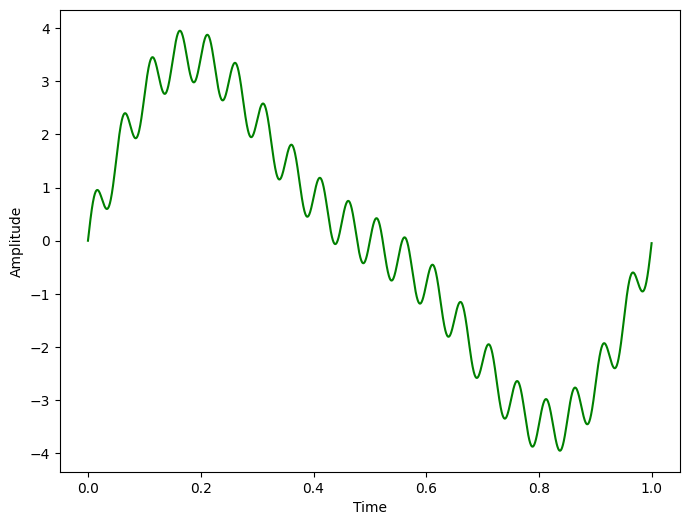

In [41]:
# define the number of samples (sampling rate)
samps = 2048
# define the sample interval
interval = 1.0/samps
t = np.arange(0,1,interval)

# set base frequency 1

additive_wave = 3*np.sin(2*np.pi*1.*t)

# add 2nd harmonic
additive_wave += np.sin(2*np.pi*2.*t)

# add 20th harmonic
additive_wave += 0.5* np.sin(2*np.pi*20.*t)

plt.figure(figsize = (8, 6))
plt.plot(t, additive_wave, 'g')
plt.ylabel('Amplitude')
plt.xlabel('Time')

plt.show()

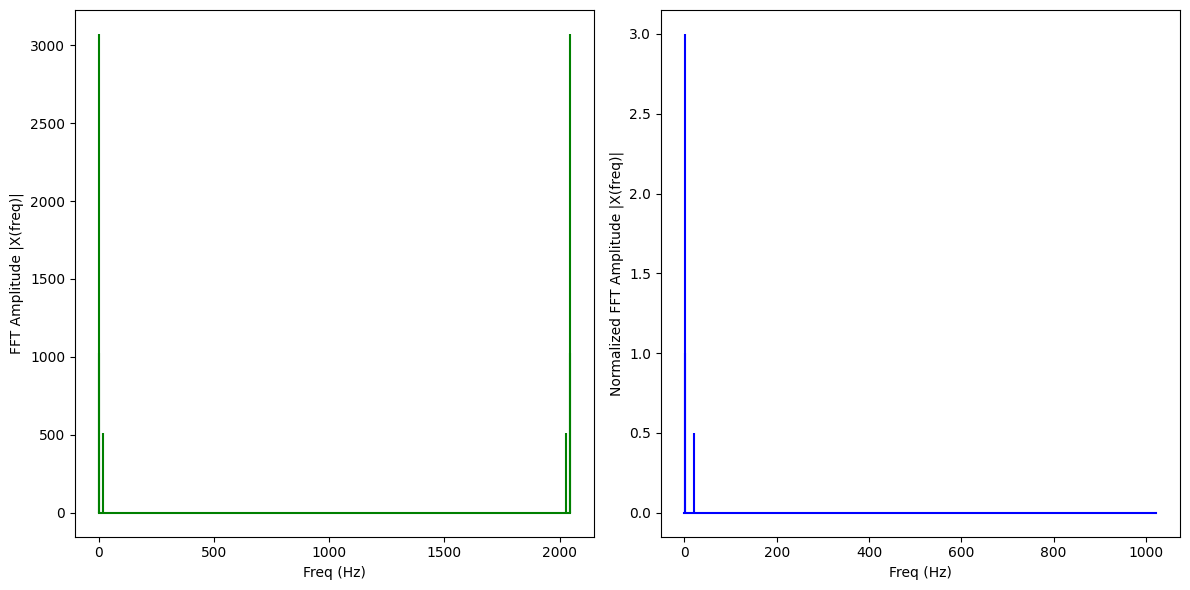

In [40]:
X=dit_FFT(additive_wave)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/samps
freq = n/T

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, abs(X), 'g',  markerfmt=" ", basefmt="-g")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Normalized FFT Amplitude |X(freq)|')
plt.tight_layout()
plt.show()

plt.show()

array([ 1.05829152e-14+0.0000000e+00j, -6.80993748e-14-3.0720000e+03j,
       -1.39279200e-13-1.0240000e+03j, ...,
       -1.26334904e-14+1.5690593e-13j, -1.49840819e-12+1.0240000e+03j,
       -4.98716912e-12+3.0720000e+03j])

## Iterative Fast Fourier Transform Algorithm